Kaggle: kousnetsovz/Захар_Кузнецов_356494781  
stepik: Захар_Кузнецов_356494781

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.

## Установка зависимостей и импорты

In [ ]:
!pip install --user torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install efficientnet_pytorch


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch
import numpy as np
import zipfile
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import PIL
import pickle
import numpy as np
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torch.utils.data import WeightedRandomSampler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from sklearn.metrics import f1_score
from efficientnet_pytorch import EfficientNet
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

C:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Проверка GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Загрузка данных

In [ ]:
with zipfile.ZipFile("journey-springfield.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

# отсортируем файлы и дадим наименование каждому изображению
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

## Анализ данных

Давайте посмотрим на наших героев внутри датасета.

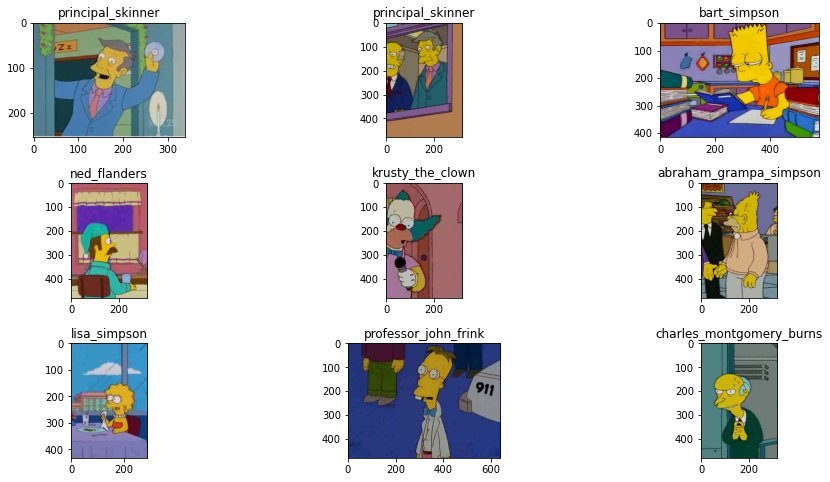

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))
fig.subplots_adjust(hspace=0.4)
for i, fig_x in enumerate(axes.flatten()):
    random_characters = int(np.random.uniform(0, len(train_val_labels)))
    im_test = Image.open(train_val_files[random_characters])
    img_label = train_val_labels[random_characters]
    axes[i//3, i%3].imshow(im_test)
    axes[i//3, i%3].set_title(img_label)
plt.show()

Посмотри на распределение картинок по классам

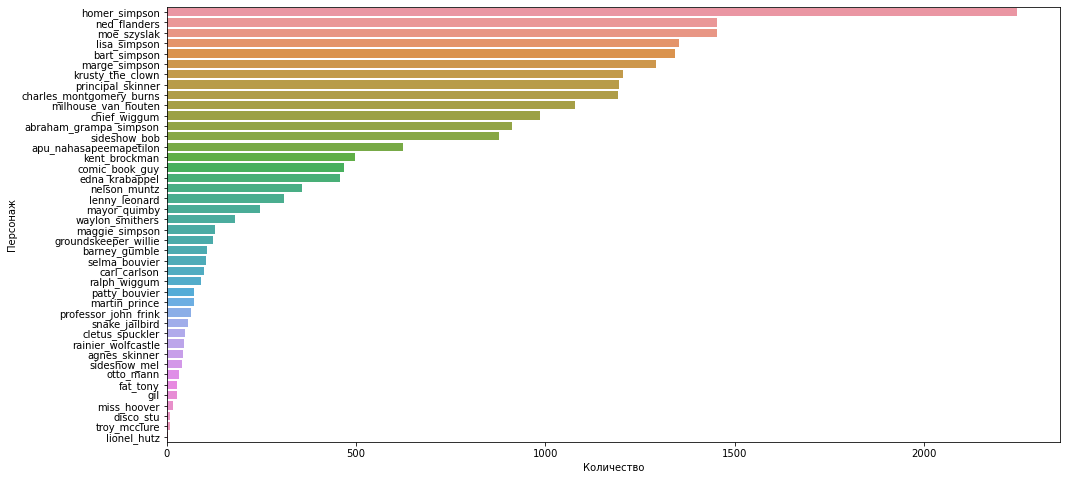

In [ ]:
imgs_by_classes =  dict(Counter(train_val_labels))
sorted_imgs_by_classes = dict(sorted(imgs_by_classes.items(), key=lambda item: item[1], reverse=True))

keys = list(sorted_imgs_by_classes.keys())
values = list(sorted_imgs_by_classes.values())
imgs_by_classes_df = pd.DataFrame({'Персонаж': keys, 'Количество': values})

plt.figure(figsize=(16,8))
sns.barplot(y='Персонаж', x='Количество', data=imgs_by_classes_df, );

## Подготовка данных

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа

        if self.mode == "train":
            augmentations = transforms.Compose([
                                    # transforms.Resize(size=300, max_size=301),
                                    transforms.Resize(size=(RESCALE_SIZE+10, RESCALE_SIZE+10)),
                                    # transforms.RandomRotation(degrees=(-20, 20)),
                                    #transforms.CenterCrop(size=280),  # transforms.RandomCrop(280),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                ])
            transform = transforms.Compose([
                                    augmentations,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])



        # transform = transforms.Compose([
        #    transforms.ToTensor(),
        #    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # ])

        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((300, 300))
        return np.array(image)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, sampler=None, optimizer=None, criterion=None):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    if not optimizer:
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    if not criterion:
        criterion = nn.CrossEntropyLoss()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Создадим имена классов из папок, в которых хранятся фото. А также разделим обучающую выборку на обучающую и валидационную

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
n_classes = len(np.unique(train_val_labels))
print(f"we will classify {n_classes} classes")

we will classify 42 classes


Создадим для каждой из выборок объект класса SimpsonsDataset

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

Создадим загрузчик данных для тестового датасета

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=111)

Загрузим сохраненный ранее кодировщик классов в порядковые номера

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

### Балансировка классов с помощью WeightedRandomSampler

In [ ]:
counts = pd.Series(train_val_labels).value_counts()

count_weights = {k: 1/v for k,v in counts.items()} # как-то странно считаются веса
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

N = counts.max() * len(count_weights)

train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

100%|████████████████████████████████████████████████████████████████████████████| 15699/15699 [03:50<00:00, 68.10it/s]


## Построение нейросети

### SimpleCnn

In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print(simple_cnn)

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=2400, out_fea

In [ ]:
model_cnn, history_cnn = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=32, sampler=train_sampler)

epoch:   0%|                                                                                    | 0/15 [00:00<?, ?it/s]

loss 1.162905481581934


epoch:   7%|████▊                                                                    | 1/15 [14:04<3:17:07, 844.81s/it]


Epoch 001 train_loss: 1.1629     val_loss 1.4430 train_acc 0.7002 val_acc 0.6460
loss 0.3360893217513366


epoch:  13%|█████████▋                                                               | 2/15 [27:35<2:58:42, 824.78s/it]


Epoch 002 train_loss: 0.3361     val_loss 1.3471 train_acc 0.9105 val_acc 0.6964
loss 0.20291847442554992


epoch:  20%|██████████████▌                                                          | 3/15 [41:09<2:43:59, 819.92s/it]


Epoch 003 train_loss: 0.2029     val_loss 1.2853 train_acc 0.9431 val_acc 0.7218
loss 0.14496431311369967


epoch:  27%|███████████████████▍                                                     | 4/15 [54:44<2:29:55, 817.81s/it]


Epoch 004 train_loss: 0.1450     val_loss 1.2870 train_acc 0.9593 val_acc 0.7495
loss 0.10812515152618841


epoch:  33%|███████████████████████▋                                               | 5/15 [1:08:17<2:16:02, 816.27s/it]


Epoch 005 train_loss: 0.1081     val_loss 1.3265 train_acc 0.9695 val_acc 0.7566
loss 0.08606483097468681


epoch:  40%|████████████████████████████▍                                          | 6/15 [1:21:55<2:02:31, 816.88s/it]


Epoch 006 train_loss: 0.0861     val_loss 1.3654 train_acc 0.9749 val_acc 0.7709
loss 0.06882027616242065


epoch:  47%|█████████████████████████████████▏                                     | 7/15 [1:35:26<1:48:38, 814.81s/it]


Epoch 007 train_loss: 0.0688     val_loss 1.4160 train_acc 0.9796 val_acc 0.7877
loss 0.031152800344822255


epoch:  53%|█████████████████████████████████████▊                                 | 8/15 [1:49:00<1:35:00, 814.42s/it]


Epoch 008 train_loss: 0.0312     val_loss 1.3539 train_acc 0.9916 val_acc 0.8038
loss 0.01863204842674852


epoch:  60%|██████████████████████████████████████████▌                            | 9/15 [2:02:35<1:21:27, 814.63s/it]


Epoch 009 train_loss: 0.0186     val_loss 1.4290 train_acc 0.9952 val_acc 0.8070
loss 0.013986260728532268


epoch:  67%|██████████████████████████████████████████████▋                       | 10/15 [2:16:07<1:07:49, 813.87s/it]


Epoch 010 train_loss: 0.0140     val_loss 1.5407 train_acc 0.9964 val_acc 0.8118
loss 0.01032783323677822


epoch:  73%|████████████████████████████████████████████████████▊                   | 11/15 [2:29:38<54:12, 813.00s/it]


Epoch 011 train_loss: 0.0103     val_loss 1.6274 train_acc 0.9975 val_acc 0.8086
loss 0.007132762475471747


epoch:  80%|█████████████████████████████████████████████████████████▌              | 12/15 [2:43:07<40:35, 811.89s/it]


Epoch 012 train_loss: 0.0071     val_loss 1.7764 train_acc 0.9984 val_acc 0.8107
loss 0.005264901962111612


epoch:  87%|██████████████████████████████████████████████████████████████▍         | 13/15 [2:56:35<27:01, 810.77s/it]


Epoch 013 train_loss: 0.0053     val_loss 1.8961 train_acc 0.9989 val_acc 0.8066
loss 0.0040321889871766095


epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [3:10:04<13:29, 809.98s/it]


Epoch 014 train_loss: 0.0040     val_loss 2.0008 train_acc 0.9990 val_acc 0.8082
loss 0.002956251215616254


epoch: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [3:23:33<00:00, 814.26s/it]


Epoch 015 train_loss: 0.0030     val_loss 2.0170 train_acc 0.9995 val_acc 0.8095
Best val Acc: 0.811807


Построим кривые обучения

In [ ]:
loss_cnn, acc_cnn, val_loss_cnn, val_acc_cnn = zip(*history_cnn)

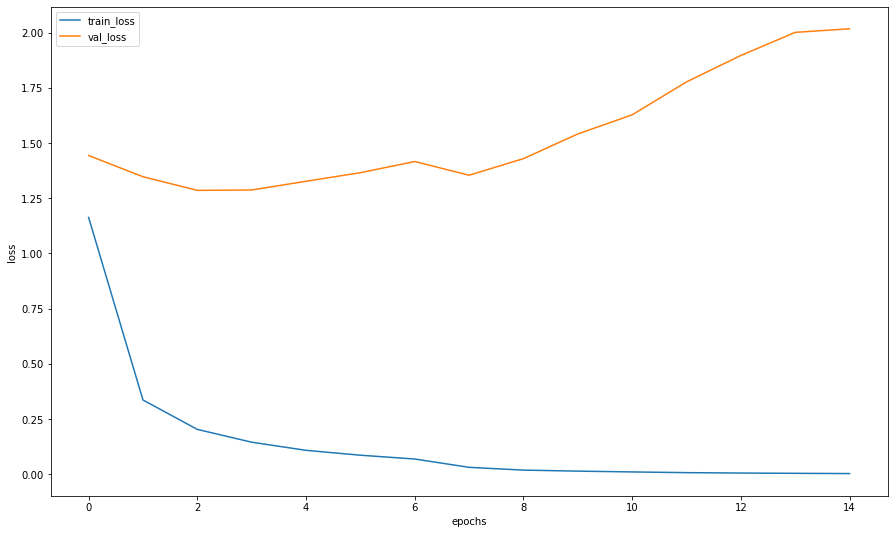

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss_cnn, label="train_loss")
plt.plot(val_loss_cnn, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### ResNet50

Возьмем готовую архитектуру ResNet50 и разморозим несколько ее последних слоев

In [ ]:
model_resnet50 = models.resnet50(pretrained=True)

model_resnet50.fc = nn.Linear(2048, n_classes)

for name, p in model_resnet50.named_parameters():
    if name.startswith("layer4.2.") or name.startswith("fc."):
        p.requires_grad = True
    else:
        p.requires_grad = False
model_resnet50 = model_resnet50.to(DEVICE)

C:\Users\Карина\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Карина\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_resnet50_trained, history_resnet50 = train(train_dataset,
                                                 val_dataset,
                                                 model=model_resnet50,
                                                 epochs=15,
                                                 batch_size=32,
                                                 sampler=train_sampler
                                                )

epoch:   0%|                                                                                    | 0/15 [00:00<?, ?it/s]

loss 0.1940307490739224


epoch:   7%|████▊                                                                   | 1/15 [20:57<4:53:25, 1257.51s/it]


Epoch 001 train_loss: 0.1940     val_loss 0.3581 train_acc 0.9565 val_acc 0.9148
loss 0.06921727305044675


epoch:  13%|█████████▌                                                              | 2/15 [41:35<4:29:58, 1246.01s/it]


Epoch 002 train_loss: 0.0692     val_loss 0.3465 train_acc 0.9812 val_acc 0.9217
loss 0.03379866014069992


epoch:  20%|██████████████                                                        | 3/15 [1:02:11<4:08:17, 1241.43s/it]


Epoch 003 train_loss: 0.0338     val_loss 0.3922 train_acc 0.9910 val_acc 0.9213
loss 0.02651812805269533


epoch:  27%|██████████████████▋                                                   | 4/15 [1:22:50<3:47:23, 1240.32s/it]


Epoch 004 train_loss: 0.0265     val_loss 0.4508 train_acc 0.9927 val_acc 0.9251
loss 0.021715712664715565


epoch:  33%|███████████████████████▎                                              | 5/15 [1:43:25<3:26:24, 1238.49s/it]


Epoch 005 train_loss: 0.0217     val_loss 0.4110 train_acc 0.9943 val_acc 0.9320
loss 0.021455155166702506


epoch:  40%|████████████████████████████                                          | 6/15 [2:04:03<3:05:44, 1238.25s/it]


Epoch 006 train_loss: 0.0215     val_loss 0.3762 train_acc 0.9948 val_acc 0.9278
loss 0.017850460899702145


epoch:  47%|████████████████████████████████▋                                     | 7/15 [2:24:38<2:44:57, 1237.20s/it]


Epoch 007 train_loss: 0.0179     val_loss 0.4279 train_acc 0.9956 val_acc 0.9327
loss 0.0011871589878716502


epoch:  53%|█████████████████████████████████████▎                                | 8/15 [2:45:14<2:24:18, 1236.97s/it]


Epoch 008 train_loss: 0.0012     val_loss 0.4252 train_acc 0.9997 val_acc 0.9425
loss 0.0007207323263393646


epoch:  60%|██████████████████████████████████████████                            | 9/15 [3:05:55<2:03:49, 1238.24s/it]


Epoch 009 train_loss: 0.0007     val_loss 0.4425 train_acc 0.9998 val_acc 0.9408
loss 0.00022975881424958287


epoch:  67%|██████████████████████████████████████████████                       | 10/15 [3:26:39<1:43:19, 1239.99s/it]


Epoch 010 train_loss: 0.0002     val_loss 0.4567 train_acc 0.9999 val_acc 0.9436
loss 4.36727060672733e-05


epoch:  73%|██████████████████████████████████████████████████▌                  | 11/15 [3:47:19<1:22:40, 1240.04s/it]


Epoch 011 train_loss: 0.0000     val_loss 0.5274 train_acc 1.0000 val_acc 0.9431
loss 0.00024941950911575175


epoch:  80%|███████████████████████████████████████████████████████▏             | 12/15 [4:08:04<1:02:04, 1241.49s/it]


Epoch 012 train_loss: 0.0002     val_loss 0.4882 train_acc 0.9999 val_acc 0.9448
loss 0.00010023239106679585


epoch:  87%|█████████████████████████████████████████████████████████████▌         | 13/15 [4:28:47<41:23, 1241.89s/it]


Epoch 013 train_loss: 0.0001     val_loss 0.5640 train_acc 1.0000 val_acc 0.9448
loss 0.00011926916305378719


epoch:  93%|██████████████████████████████████████████████████████████████████▎    | 14/15 [4:49:32<20:42, 1242.81s/it]


Epoch 014 train_loss: 0.0001     val_loss 0.5467 train_acc 1.0000 val_acc 0.9436
loss 0.00010124086961485642


epoch: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [5:10:19<00:00, 1241.33s/it]


Epoch 015 train_loss: 0.0001     val_loss 0.5367 train_acc 0.9999 val_acc 0.9448
Best val Acc: 0.944784


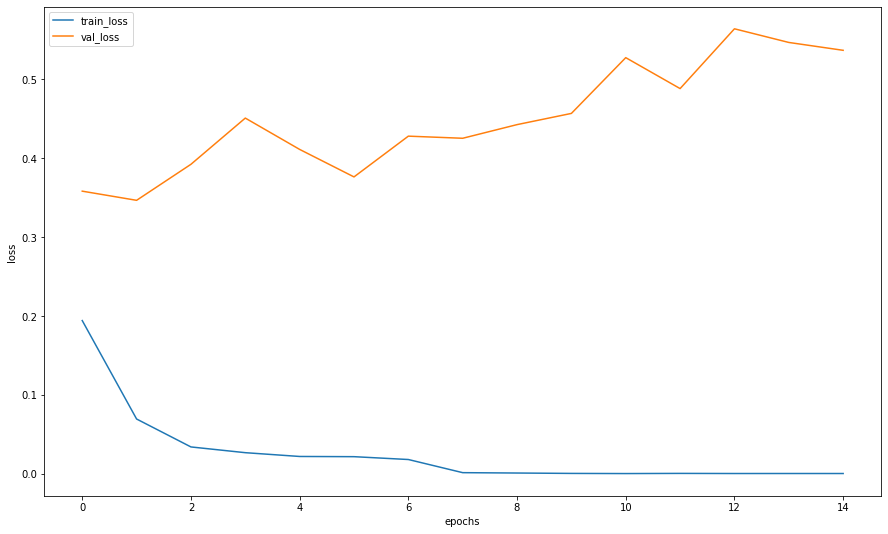

In [ ]:
loss_resnet50, acc_resnet50, val_loss_resnet50, val_acc_resnet50 = zip(*history_resnet50)

plt.figure(figsize=(15, 9))
plt.plot(loss_resnet50, label="train_loss")
plt.plot(val_loss_resnet50, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model_resnet50_probs = predict(model_resnet50_trained, test_loader)

model_resnet50_preds = label_encoder.inverse_transform(np.argmax(model_resnet50_probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
model_resnet50_submit = pd.DataFrame({'Id': test_filenames, 'Expected': model_resnet50_preds})
model_resnet50_submit.head(5)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
model_resnet50_submit.to_csv('model_resnet50_submit.csv', index=False)

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet50_trained, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet50_trained, imgs)

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


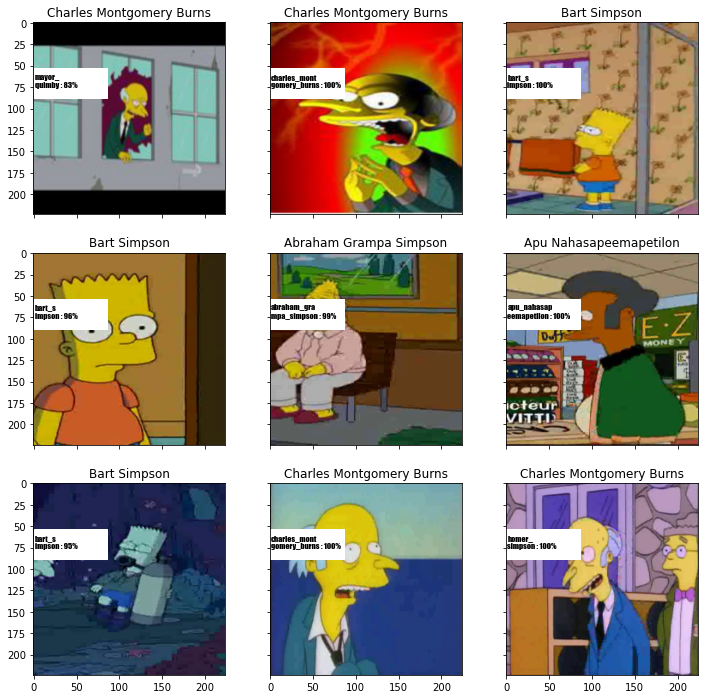

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### RESNEXT50_32X4D

Будем использовать модель resnext50_32x4d
https://pytorch.org/vision/main/models/generated/torchvision.models.resnext50_32x4d.html

In [ ]:
rn50 = models.resnext50_32x4d(pretrained=True)
for name, p in rn50.named_parameters():
    print(name)

C:\Users\Карина\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Карина\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

Заменим последний слой на полносвязный с нужным нам количеством выходов, соответствующим числу классов

In [ ]:
in_ftrs = rn50.fc.in_features
rn50.fc = nn.Linear(in_ftrs, n_classes)

Сделаем достуными для изменения только "четвертый блок слоев" и фиальный полносвязный

In [ ]:
for name, p in rn50.named_parameters():
    if not 'layer4.2' in name and not 'fc' in name:
        p.requires_grad = False
    else:
        p.requires_grad = True

In [ ]:
rn50.to(DEVICE)

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
# optimizer = torch.optim.AdamW(model_extractor.classifier.parameters())

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, rn50.parameters()), lr=0.001)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
rn50_trained, history_rn50 = train(train_dataset,
                                                 val_dataset,
                                                 model=rn50,
                                                 epochs=20,
                                                 batch_size=32,
                                                 sampler=train_sampler
                                                )

epoch:   0%|                                                                                    | 0/20 [00:00<?, ?it/s]

loss 0.16620126643895336


epoch:   5%|███▌                                                                    | 1/20 [24:17<7:41:36, 1457.71s/it]


Epoch 001 train_loss: 0.1662     val_loss 0.3536 train_acc 0.9620 val_acc 0.9133
loss 0.04484693102170531


epoch:  10%|███████▏                                                                | 2/20 [48:02<7:11:26, 1438.12s/it]


Epoch 002 train_loss: 0.0448     val_loss 0.6815 train_acc 0.9875 val_acc 0.8741
loss 0.024327155380649577


epoch:  15%|██████████▌                                                           | 3/20 [1:11:40<6:44:54, 1429.10s/it]


Epoch 003 train_loss: 0.0243     val_loss 0.5691 train_acc 0.9934 val_acc 0.9133
loss 0.022140229486833016


epoch:  20%|██████████████                                                        | 4/20 [1:35:22<6:20:18, 1426.13s/it]


Epoch 004 train_loss: 0.0221     val_loss 0.4560 train_acc 0.9940 val_acc 0.9232
loss 0.018346665321053546


epoch:  25%|█████████████████▌                                                    | 5/20 [1:59:03<5:56:04, 1424.31s/it]


Epoch 005 train_loss: 0.0183     val_loss 0.4830 train_acc 0.9956 val_acc 0.9324
loss 0.014094275780531677


epoch:  30%|█████████████████████                                                 | 6/20 [2:22:39<5:31:42, 1421.59s/it]


Epoch 006 train_loss: 0.0141     val_loss 0.9115 train_acc 0.9964 val_acc 0.8930
loss 0.01513458699578382


epoch:  35%|████████████████████████▌                                             | 7/20 [2:46:16<5:07:39, 1419.95s/it]


Epoch 007 train_loss: 0.0151     val_loss 0.5703 train_acc 0.9965 val_acc 0.9293
loss 0.001245711979573048


epoch:  40%|████████████████████████████                                          | 8/20 [3:09:49<4:43:35, 1417.94s/it]


Epoch 008 train_loss: 0.0012     val_loss 0.5652 train_acc 0.9997 val_acc 0.9347
loss 0.00036100449749714396


epoch:  45%|███████████████████████████████▌                                      | 9/20 [3:33:20<4:19:31, 1415.63s/it]


Epoch 009 train_loss: 0.0004     val_loss 0.5775 train_acc 0.9999 val_acc 0.9375
loss 0.0001727531279657571


epoch:  50%|██████████████████████████████████▌                                  | 10/20 [3:56:52<3:55:46, 1414.69s/it]


Epoch 010 train_loss: 0.0002     val_loss 0.6400 train_acc 0.9999 val_acc 0.9377
loss 0.0001320396291452239


epoch:  55%|█████████████████████████████████████▉                               | 11/20 [4:20:30<3:32:19, 1415.48s/it]


Epoch 011 train_loss: 0.0001     val_loss 0.7064 train_acc 0.9999 val_acc 0.9364
loss 0.00011963522369981239


epoch:  60%|█████████████████████████████████████████▍                           | 12/20 [4:44:08<3:08:51, 1416.47s/it]


Epoch 012 train_loss: 0.0001     val_loss 0.6676 train_acc 1.0000 val_acc 0.9385
loss 0.00013292356105123242


epoch:  65%|████████████████████████████████████████████▊                        | 13/20 [5:07:49<2:45:24, 1417.78s/it]


Epoch 013 train_loss: 0.0001     val_loss 0.6817 train_acc 1.0000 val_acc 0.9394
loss 0.0001318959461476921


epoch:  70%|████████████████████████████████████████████████▎                    | 14/20 [5:31:27<2:21:47, 1417.84s/it]


Epoch 014 train_loss: 0.0001     val_loss 0.6523 train_acc 0.9999 val_acc 0.9400
loss 4.7692254815320174e-05


epoch:  75%|███████████████████████████████████████████████████▊                 | 15/20 [5:55:04<1:58:07, 1417.42s/it]


Epoch 015 train_loss: 0.0000     val_loss 0.6637 train_acc 1.0000 val_acc 0.9402
loss 8.48677242158164e-05


epoch:  80%|███████████████████████████████████████████████████████▏             | 16/20 [6:18:39<1:34:27, 1416.98s/it]


Epoch 016 train_loss: 0.0001     val_loss 0.6924 train_acc 0.9999 val_acc 0.9394
loss 6.264904135134252e-05


epoch:  85%|██████████████████████████████████████████████████████████▋          | 17/20 [6:42:13<1:10:47, 1415.93s/it]


Epoch 017 train_loss: 0.0001     val_loss 0.7091 train_acc 1.0000 val_acc 0.9391
loss 5.495252041225593e-05


epoch:  90%|███████████████████████████████████████████████████████████████▉       | 18/20 [7:05:46<47:10, 1415.08s/it]


Epoch 018 train_loss: 0.0001     val_loss 0.7389 train_acc 1.0000 val_acc 0.9391
loss 9.582284643213215e-05


epoch:  95%|███████████████████████████████████████████████████████████████████▍   | 19/20 [7:29:18<23:34, 1414.23s/it]


Epoch 019 train_loss: 0.0001     val_loss 0.7583 train_acc 0.9999 val_acc 0.9394
loss 0.00010354351540105827


epoch: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [7:52:52<00:00, 1418.61s/it]


Epoch 020 train_loss: 0.0001     val_loss 0.7712 train_acc 0.9999 val_acc 0.9394
Best val Acc: 0.940199


In [ ]:
rn50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
rn50_probs = predict(rn50_trained, test_loader)

rn50_preds = label_encoder.inverse_transform(np.argmax(rn50_probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
rn50_submit = pd.DataFrame({'Id': test_filenames, 'Expected': rn50_preds})
rn50_submit.head(5)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
rn50_submit.to_csv('rn50_submit.csv', index=False)